In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy import integrate
import os
from scipy.signal import argrelextrema

import pymc3 as pm

In [2]:
# i like my ticks big
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13

In [3]:

us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')


all_states = np.unique(us_confirmed.Province_State.values)
all_states = np.delete(all_states, np.argwhere(all_states == 'American Samoa'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Diamond Princess'))
all_states = np.delete(all_states, np.argwhere(all_states == 'District of Columbia'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Grand Princess'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Guam'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Northern Mariana Islands'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Puerto Rico'))
all_states = np.delete(all_states, np.argwhere(all_states == 'Virgin Islands'))

r0_grid = np.linspace(0,5,num=1000)


In [7]:
def raw_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:] # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:] # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

def smooth_data(state,window = 7):
    df = raw_data(state)
    
    df.confirmed = df.confirmed.diff()
    df.deaths = df.deaths.diff()
    
    
    df = df.rolling(window=window,center=True,min_periods=1).mean() # rolling mean window to smoothen out data
    df = df.round()
    df = df.clip(lower = 1)
    return df

In [8]:
def mean(dist_array):
    mu = np.sum(dist_array * r0_grid)/np.sum(dist_array)    
    return mu
    
def zero_crossing(array):
    return np.where(np.diff(np.signbit(array)))[0]
    
# Binary search to calculate 95% HPD
def hpd(dist_array,interval = 0.95,iterations=50):
    y_up = np.max(dist_array) 
    y_lo = 0.0
    
    for i in range(iterations):
        y_m = (y_lo + y_up)*0.5

        intersections = zero_crossing(dist_array - y_m)

        if len(intersections) == 1:
            #only 1 crossing check if right or left is bigger:
            if dist_array[-1] > dist_array[0]:
                x_loc = [intersections[0],len(dist_array)-1]
            else:
                x_loc = [0,intersections[0]]
        elif len(intersections) == 2:
            x_loc = intersections
        else:
            print('Error: number of intersections > 2')
      
        y_vals = dist_array[x_loc[0]:x_loc[1]]
        mass = np.sum(y_vals)

        if mass < interval:
            y_up = y_m
        elif mass > interval:
            y_lo = y_m
    
    return r0_grid[x_loc]

In [9]:
state_name = 'Arizona'
image_dir = 'images/'+state_name
if (not os.path.exists(image_dir)):
    os.mkdir(image_dir)

smoothing_window = 7
state = smooth_data(state_name,window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(state_name) # raw daily case and death counts 

len(raw) == len(state)

True

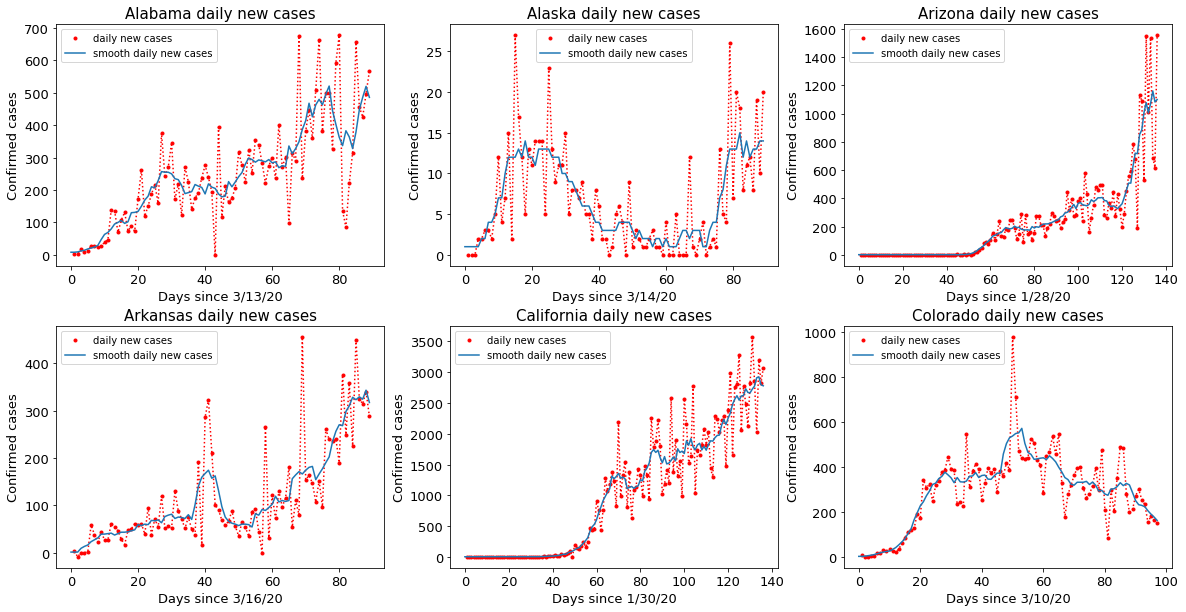

In [13]:
states_to_plot = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado']

figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(231)
i = 0
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)

plt.subplot(232)
i = 1
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)

plt.subplot(233)
i = 2
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)


plt.subplot(234)
i = 3
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts

plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)

plt.subplot(235)
i = 4
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)


plt.subplot(236)
i = 5
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i])# raw daily case and death counts
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.arange(len(raw)),raw.confirmed.diff(), 'r:')
plt.plot(np.arange(len(state)),state.confirmed,label = 'smooth daily new cases')
plt.xlabel('Days since '+ state.index[i],fontsize = 13)
plt.ylabel('Confirmed cases',fontsize = 13)
plt.legend()
plt.title(states_to_plot[i] +' daily new cases',fontsize=15)
plt.savefig('images/daily_cases.pdf')


In [14]:
len(raw) == len(state)

True

Show posteriors for different states

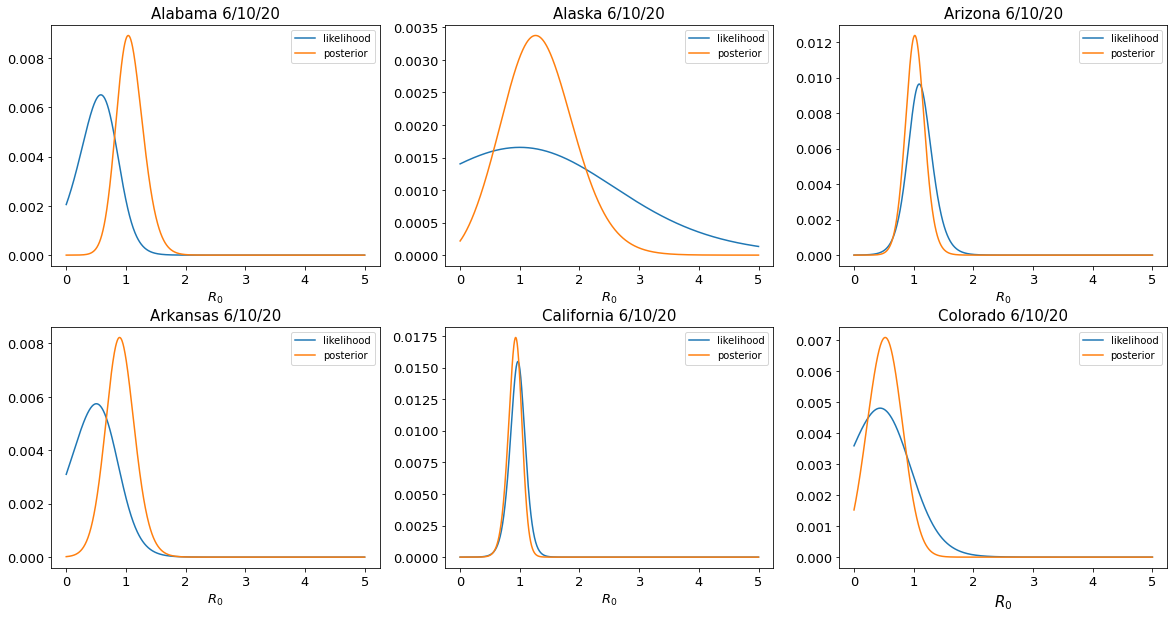

In [15]:
states_to_plot = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado']


figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(231)
i = 0
posterior_data = np.load('images/'+ states_to_plot[0] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[0] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)
plt.legend()


plt.subplot(232)
i = 1
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[i] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)
plt.legend()

plt.subplot(233)
i = 2
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[i] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)
plt.legend()

plt.subplot(234)
i = 3
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[i] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)
plt.legend()

plt.subplot(235)
i = 4
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[i] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 13)
plt.legend()

plt.subplot(236)
i = 5
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
plt.title(states_to_plot[i] +' '+ posterior_data[-1][0]['date'],fontsize = 15)
plt.plot(r0_grid,posterior_data[-1][0]['likehood'],label = 'likelihood')
plt.plot(r0_grid,posterior_data[-1][0]['posterior'],label = 'posterior')
plt.xlabel('$R_0$',fontsize = 15)
plt.legend()
plt.savefig('images/posteriors.pdf')

In [16]:
def computeMeanHpd(posterior_data):
    meanHPD = []
    for day in posterior_data:
        date = day[0]['date']
        post = day[0]['posterior']
        meanHPD.append([date,mean(post),hpd(post)])
    return np.array(meanHPD)
        

In [17]:
def rt_timePlot(meanhpdData,name,**kwargs):
    
    up = [meanhpdData[i,2][1] for i in range(len(meanhpdData))]
    lo = [meanhpdData[i,2][0] for i in range(len(meanhpdData))]
    
    plt.fill_between(np.arange(len(up)),
                      up,lo, 
                      color = 'red', alpha = 0.1 )

    plt.plot(np.arange(previousDays),meanhpdData[:,1],**kwargs,color = 'red')

    plt.hlines(1,0,previousDays,linestyle = ':')
    plt.xlabel('Days',fontsize =15)
    plt.ylabel('R0 estimate',fontsize =15)
    #plt.legend(fontsize = 13)
    plt.title(name+' $R_t$',fontsize = 15)

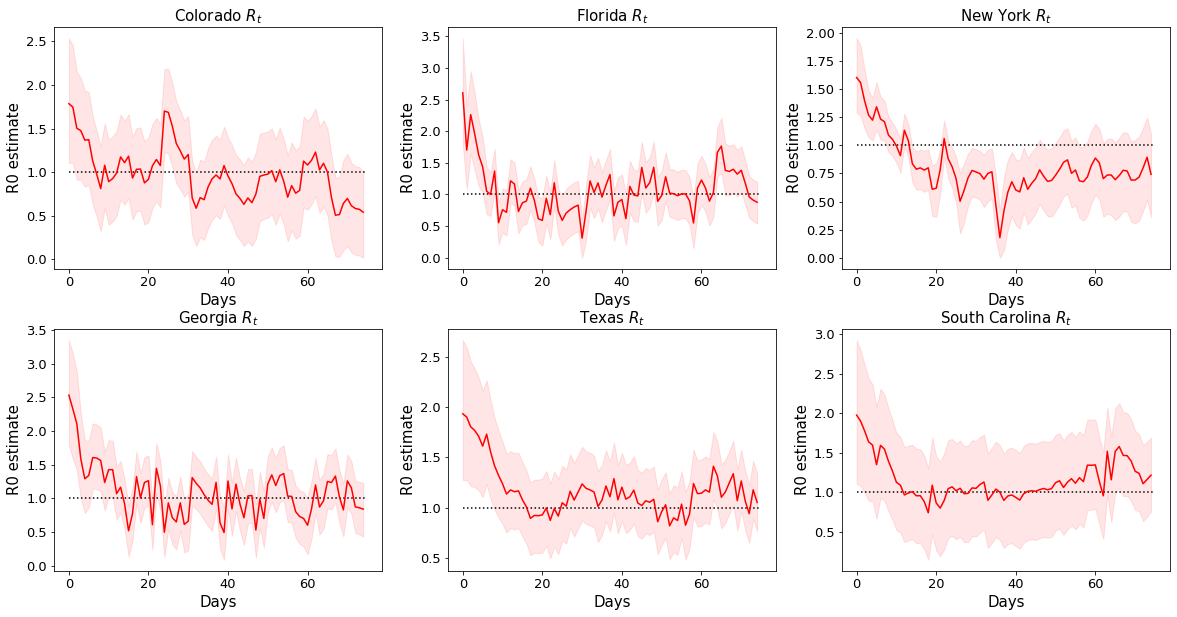

In [18]:
previousDays = 75
states_to_plot = ['Colorado','Florida','New York','Georgia','Texas','South Carolina']

figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(231)
i = 0
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])

plt.subplot(232)
i = 1
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])


plt.subplot(233)
i = 2
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])


plt.subplot(234)
i = 3
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])


plt.subplot(235)
i = 4
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])


plt.subplot(236)
i = 5
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i])

plt.savefig('images/r0time.pdf')

# Compare with RKI

In [21]:
def rki_R0(state, gt = 4,samples = 100):
    r0 = []
    for i in np.arange(gt*2, len(state) + 1):
        y2 = np.sum(state.confirmed[i-gt:i])
        y1 = np.sum(state.confirmed[i-2*gt :i- gt])
        
        r0_sample = stats.poisson.rvs(y2,size = samples)/stats.poisson.rvs(y1,size = samples)
        
        r0.append({'date':state.index[i-1], 'R0':r0_sample})
    
    return r0
    

In [22]:
def rki_plot(state_name,previousDays):
    state  = smooth_data(state_name)[-previousDays:]
    rki_data = rki_R0(state)
    
    shift_gt = len(state) - len(rki_data)
    
    rki_mean = [np.mean(rki_data[i]['R0']) for i in range(len(rki_data))]
    rki_hpd = [pm.hpd(rki_data[i]['R0']) for i in range(len(rki_data))]
    lo = [rki_hpd[i][0] for i in range(len(rki_hpd))]
    up = [rki_hpd[i][1] for i in range(len(rki_hpd))]
    
    plt.fill_between(np.arange(len(rki_data))+shift_gt,
                  up,lo, 
                  color = 'green', alpha = 0.2 )
    plt.plot(np.arange(len(rki_data))+shift_gt,rki_mean, color = 'green', label = 'RKI $R_t$')

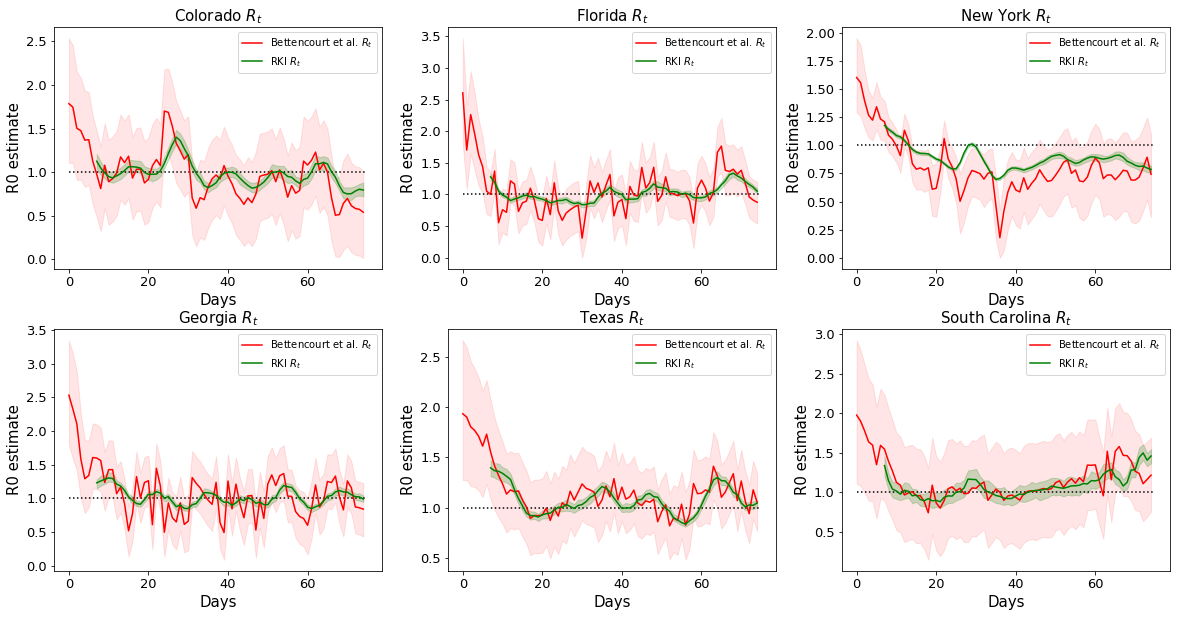

In [24]:
previousDays = 75
states_to_plot = ['Colorado','Florida','New York','Georgia','Texas','South Carolina']

figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(231)

i = 0
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()


plt.subplot(232)
i = 1
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()


plt.subplot(233)
i = 2
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()


plt.subplot(234)
i = 3
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()


plt.subplot(235)
i = 4
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()


plt.subplot(236)
i = 5
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
meanhpdData = computeMeanHpd(posterior_data[-previousDays:])
rt_timePlot(meanhpdData,states_to_plot[i],label = 'Bettencourt et al. $R_t$')
rki_plot(states_to_plot[i],previousDays)
plt.legend()

plt.savefig('images/compareR0.pdf')

## Extrapolate:

In [25]:
# draw R0 from the current posterior using the inverse CDF method

def draw_r0(posterior,size = 1):
    cdf = np.cumsum(posterior)
    cdf /= cdf[-1]
    
    samples = np.zeros(size)
    for i in range(size):
        u = np.random.rand()

        loc = np.argmin(np.abs(cdf - u))
        samples[i] = r0_grid[loc]
        
        
    if size == 1: 
        return samples[0]
    else:
        return samples
    
    

# draw gamma from the appropriate log-normal distribution
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma

def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out

In [27]:
def extrapolate(r,g,days=20):
    proj = [state.confirmed[-1]]
    for i in range(days):
        tomorrow = newcases(proj[-1],g,r) # model prediction
        tomorrow = stats.poisson.rvs(tomorrow) # including poisson noise
        proj.append(tomorrow)
    return np.array(proj)

In [28]:
def plot_observed_cases(state):
    time = np.arange(len(state.confirmed))
    plt.plot(time, state.confirmed,'ro',markersize = 3)
    plt.plot(time, state.confirmed,'r:')


def plot_projection(preds,**kwargs):
    time = np.arange(len(state.confirmed))
    future_time = np.arange(len(time) -1 ,len(time) + len(preds) -1)
    plt.plot(future_time,preds,**kwargs)
    
def all_projections(latest_posterior): 
    for _ in range(1000):
        r0 = draw_r0(latest_posterior)
        g = draw_gamma()
        plot_projection(extrapolate(r0,g),alpha = 0.01,color = 'black')
        plt.ylim(0,np.max(state.confirmed)*1.3)

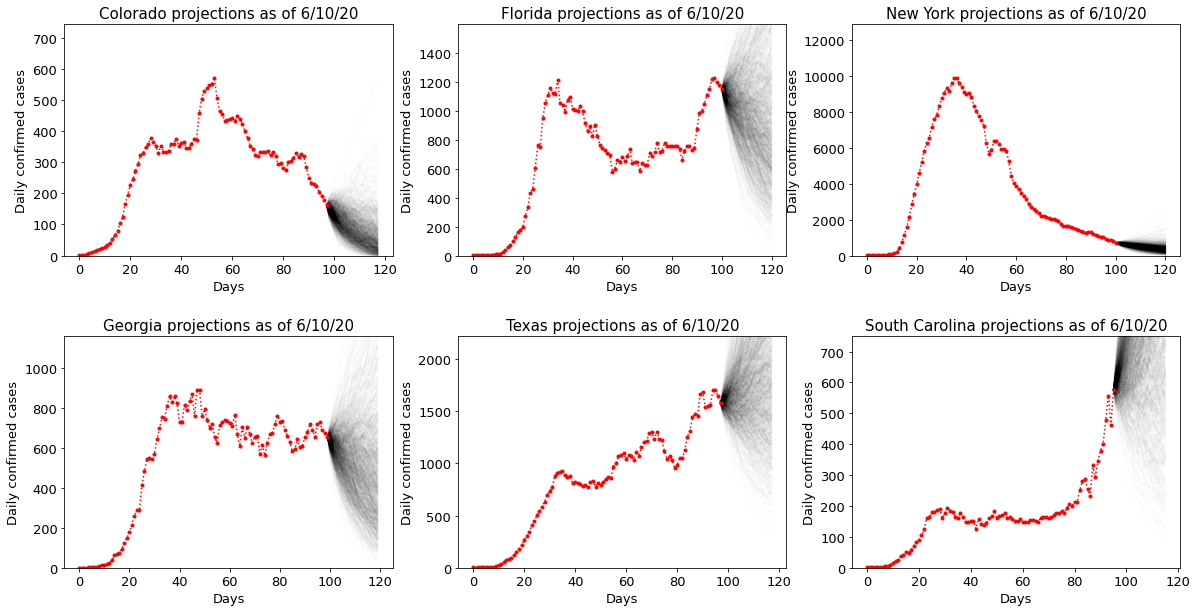

In [30]:
states_to_plot = ['Colorado','Florida','New York','Georgia','Texas','South Carolina']

figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.35)

plt.subplot(231)
i = 0
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
all_projections(latest_posterior)
plot_observed_cases(state)
plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(232)
i = 1
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']

all_projections(latest_posterior)
plot_observed_cases(state)

plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(233)
i = 2
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']

all_projections(latest_posterior)
plot_observed_cases(state)

plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(234)
i = 3
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']

all_projections(latest_posterior)
plot_observed_cases(state)

plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(235)
i = 4
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']

all_projections(latest_posterior)
plot_observed_cases(state)

plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)

plt.subplot(236)
i = 5
state = smooth_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']

all_projections(latest_posterior)
plot_observed_cases(state)

plt.ylabel('Daily confirmed cases',fontsize = 13)
plt.xlabel('Days',fontsize = 13)
plt.title(states_to_plot[i]+' daily case count projections',fontsize = 15)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)
plt.savefig('images/predict_cases.pdf')



In [31]:
def death_project(r,g,days = 20,**kwargs):
    cfr = np.random.poisson(raw.deaths[-1])/np.random.poisson(raw.confirmed[-1])

    future_cases = extrapolate(r,g,days=20)[1:]
    future_deaths = np.cumsum(future_cases) * cfr 
    future_deaths += raw.deaths[-1]  # add in current death toll
    future_deaths = stats.poisson.rvs(future_deaths)

    future_deaths = np.insert(future_deaths,0,raw.deaths[-1])#add current deaths as first index

    time = np.arange(len(raw.confirmed))
    future_time = np.arange(len(time) -1 ,len(time) + days )
    plt.plot(future_time,future_deaths,**kwargs)

In [32]:
def plot_all_death_projections(raw,latest_posterior):
    for _ in range(300):
        r = draw_r0(latest_posterior)
        g = draw_gamma()
        death_project(r,g,alpha = 0.01,color = 'black')
    plt.plot(raw.deaths.values,'ro',markersize = 4)
    plt.plot(raw.deaths.values,'r:')

    plt.xlabel('Days',fontsize = 13)
    plt.ylabel('total death count',fontsize = 13)
    plt.ylim(0,np.max(raw.deaths.values)*1.3)
    plt.title(states_to_plot[i]+' death projections',fontsize = 15)


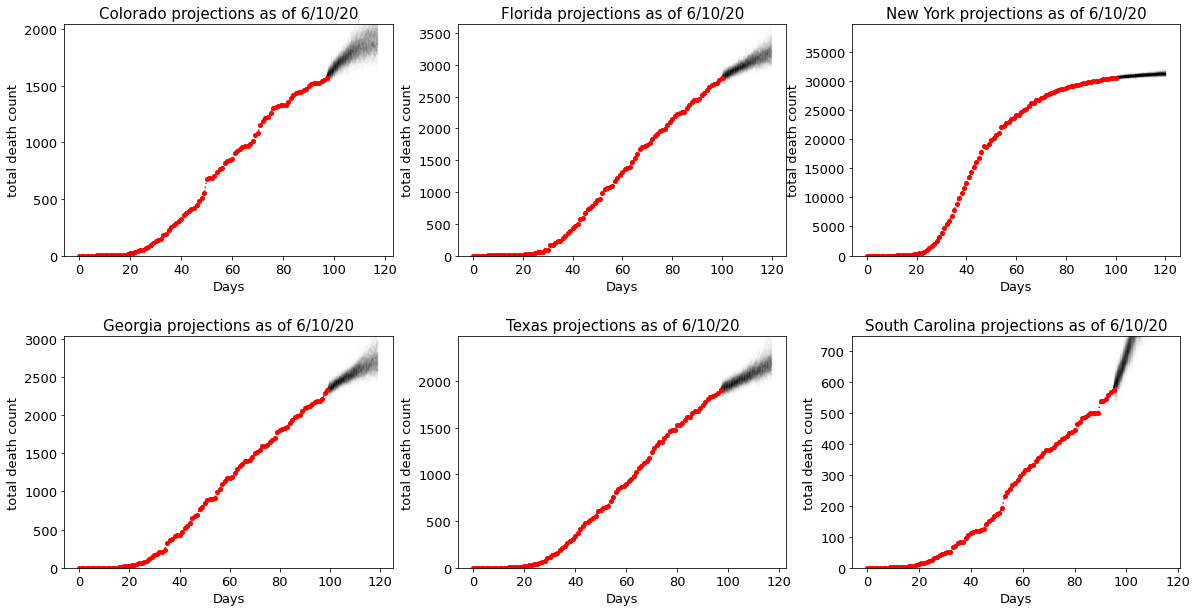

In [33]:
states_to_plot = ['Colorado','Florida','New York','Georgia','Texas','South Carolina']

figure = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.35)

plt.subplot(231)
i = 0
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(232)
i = 1
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(233)
i = 2
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(234)
i = 3
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(235)
i = 4
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)


plt.subplot(236)
i = 5
raw = raw_data(states_to_plot[i])
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)
latest_posterior = posterior_data[-1][0]['posterior']
plot_all_death_projections(raw,latest_posterior)
plt.title(states_to_plot[i]+' projections as of ' + posterior_data[-1][0]['date'],fontsize = 15)

plt.savefig('images/predict_deaths.pdf')


In [34]:
def predict_cases(day,ndraws = 100):
    
    assert day >= 2, 'day >= 2'
    
    yesterday_post = posterior_data[day - 2][0]['posterior']
    yesterday_cases = state.confirmed[day - 1]
    all_preds = []
    
    for _ in range(ndraws):
        r = draw_r0(yesterday_post)
        g = draw_gamma()
        pred = newcases(yesterday_cases,g,r)
        pred = stats.poisson.rvs(pred) # remember to add poisson noise
        all_preds.append(pred)
        
    all_preds = np.array(all_preds)

    return np.mean(all_preds),pm.hpd(all_preds,credible_interval=0.95)

In [35]:
def make_all_predicts(state):
    days = np.arange(len(state))[2:]
    all_predicts = []
    for i in days:
        all_predicts.append(predict_cases(i))
    return all_predicts

In [39]:
def plot_predictions(state,all_predicts):
    for d in np.arange(len(state))[2:]:
        pred = all_predicts[d - 2]
        plt.scatter(d,pred[0],color = 'black',s = 10,alpha = 0.3)
        bars_hpd = np.abs((pred[1] - pred[0])[:,None])
        plt.errorbar(d,pred[0],bars_hpd,color = 'black',alpha = 0.3)

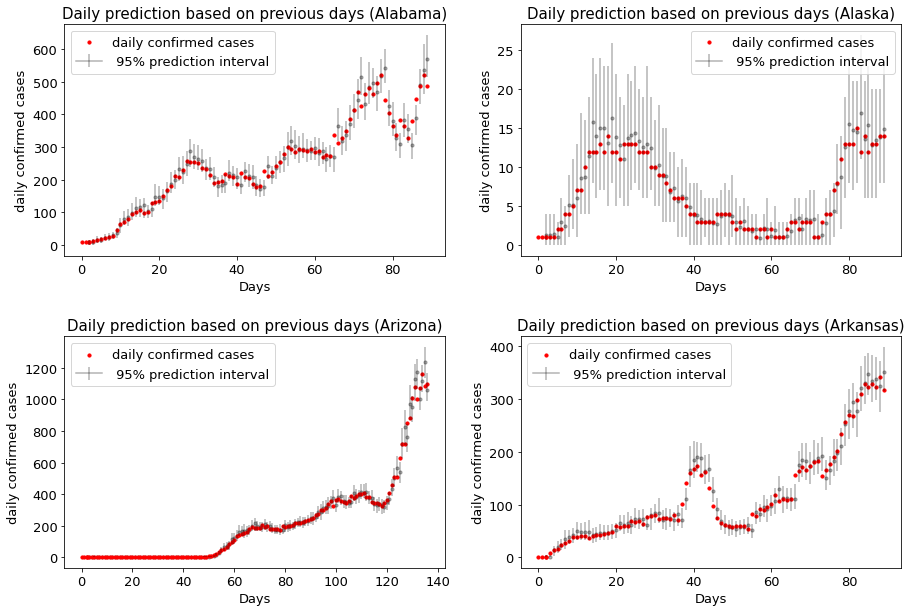

In [41]:
# Now plot predictions:
figure = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.35)

states_to_plot = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado']

plt.subplot(221)
i = 0
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts 
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)

all_predicts = make_all_predicts(state)
plot_predictions(state,all_predicts)
plt.scatter(np.arange(len(state)),state.confirmed.values,color = 'red',s = 10)
plt.xlabel('Days',fontsize = 13)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.errorbar(i,0,0,color = 'black',label = ' 95% prediction interval',alpha=0.3)
plt.scatter(2,state.confirmed.values[2],color = 'red',s = 10,label = 'daily confirmed cases')
plt.legend(fontsize = 13)
plt.title('Daily prediction based on previous days ({})'.format(states_to_plot[i]),fontsize = 15)


plt.subplot(222)
i = 1
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i]) # raw daily case and death counts 
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)

all_predicts = make_all_predicts(state)
plot_predictions(state,all_predicts)
plt.scatter(np.arange(len(state)),state.confirmed.values,color = 'red',s = 10)
plt.xlabel('Days',fontsize = 13)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.errorbar(i,0,0,color = 'black',label = ' 95% prediction interval',alpha=0.3)
plt.scatter(2,state.confirmed.values[2],color = 'red',s = 10,label = 'daily confirmed cases')
plt.legend(fontsize = 13)
plt.title('Daily prediction based on previous days ({})'.format(states_to_plot[i]),fontsize = 15)


plt.subplot(223)
i = 2
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i])# raw daily case and death counts 
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)

all_predicts = make_all_predicts(state)
plot_predictions(state,all_predicts)
plt.scatter(np.arange(len(state)),state.confirmed.values,color = 'red',s = 10)
plt.xlabel('Days',fontsize = 13)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.errorbar(i,0,0,color = 'black',label = ' 95% prediction interval',alpha=0.3)
plt.scatter(2,state.confirmed.values[2],color = 'red',s = 10,label = 'daily confirmed cases')
plt.legend(fontsize = 13)
plt.title('Daily prediction based on previous days ({})'.format(states_to_plot[i]),fontsize = 15)



plt.subplot(224)
i = 3
state = smooth_data(states_to_plot[i],window=smoothing_window) # smoothened data with mean filter of 7 day
raw = raw_data(states_to_plot[i])# raw daily case and death counts 
posterior_data = np.load('images/'+ states_to_plot[i] +'/posterior_data.npy',allow_pickle=True)

all_predicts = make_all_predicts(state)
plot_predictions(state,all_predicts)
plt.scatter(np.arange(len(state)),state.confirmed.values,color = 'red',s = 10)
plt.xlabel('Days',fontsize = 13)
plt.ylabel('daily confirmed cases',fontsize = 13)
plt.errorbar(i,0,0,color = 'black',label = ' 95% prediction interval',alpha=0.3)
plt.scatter(2,state.confirmed.values[2],color = 'red',s = 10,label = 'daily confirmed cases')
plt.legend(fontsize = 13)
plt.title('Daily prediction based on previous days ({})'.format(states_to_plot[i]),fontsize = 15)
plt.savefig('images/validation.pdf')